In [3]:
#import
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt


In [24]:
df_MSFT = pd.read_csv("./dataset_MSFT_Stock/MSFT_Stock.csv", index_col=0)
df_MSFT.index = pd.to_datetime(df_MSFT.index)
df_MSFT.resample('Q').mean().head()
new_df_MSFT = df_MSFT.resample('Q').mean()[['volume']]

new_df_MSFT.head()
new_df_MSFT.index = pd.period_range('2001Q1', '2021Q1', freq='Q')
new_df_MSFT

,volume
2001Q1,9.379107e+07
2001Q2,8.416334e+07
2001Q3,6.982918e+07
2001Q4,6.342107e+07
2002Q1,5.940865e+07
...,...
2020Q1,4.933402e+07
2020Q2,3.177283e+07
2020Q3,2.635289e+07
2020Q4,2.603498e+07


<AxesSubplot:>

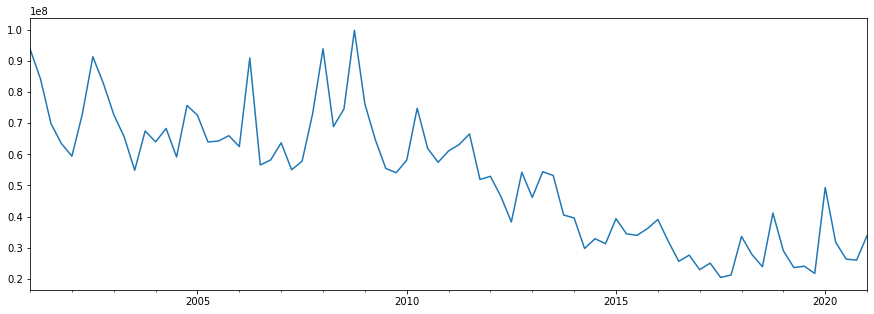

In [21]:
endog = new_df_MSFT['volume']
endog.plot(figsize=(15, 5))

In [22]:
# Construct the model
mod = sm.tsa.SARIMAX(endog, order=(1, 0, 0), trend='c')
# Estimate the parameters
res = mod.fit()

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                 volume   No. Observations:                   81
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1428.653
Date:                Fri, 30 Dec 2022   AIC                           2863.306
Time:                        18:09:35   BIC                           2870.489
Sample:                    03-31-2001   HQIC                          2866.188
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.626e+06   2.12e-10   4.06e+16      0.000    8.63e+06    8.63e+06
ar.L1          0.8424      0.015     58.041      0.000       0.814       0.871
sigma2      1.151e+14   4.13e-18   2.79e+31      0.0

In [12]:
# The default is to get a one-step-ahead forecast:
print(res.forecast())

2021-06-30    3.720598e+07
Freq: Q-DEC, dtype: float64


In [13]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast()

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

volume              mean       mean_se  mean_ci_lower  mean_ci_upper
2021-06-30  3.720598e+07  1.073039e+07   1.955606e+07   5.485590e+07


In [14]:
print(res.forecast(steps=2))

2021-06-30    3.720598e+07
2021-09-30    3.996882e+07
Freq: Q-DEC, Name: predicted_mean, dtype: float64


In [15]:
fcast_res2 = res.get_forecast(steps=2)
# Note: since we did not specify the alpha parameter, the
# confidence level is at the default, 95%
print(fcast_res2.summary_frame())

volume              mean       mean_se  mean_ci_lower  mean_ci_upper
2021-06-30  3.720598e+07  1.073039e+07   1.617480e+07   5.823716e+07
2021-09-30  3.996882e+07  1.403041e+07   1.246972e+07   6.746792e+07


In [31]:
print(res.forecast(5))

2021Q2    3.720598e+07
2021Q3    3.996882e+07
2021Q4    4.229627e+07
2022Q1    4.425695e+07
2022Q2    4.590865e+07
Freq: Q-DEC, Name: predicted_mean, dtype: float64


In [32]:
fcast_res3 = res.get_forecast(5)
print(fcast_res3.summary_frame())

volume          mean       mean_se  mean_ci_lower  mean_ci_upper
2021Q2  3.720598e+07  1.073039e+07   1.617480e+07   5.823716e+07
2021Q3  3.996882e+07  1.403041e+07   1.246972e+07   6.746792e+07
2021Q4  4.229627e+07  1.596370e+07   1.100800e+07   7.358454e+07
2022Q1  4.425695e+07  1.720438e+07   1.053698e+07   7.797692e+07
2022Q2  4.590865e+07  1.803314e+07   1.056434e+07   8.125295e+07


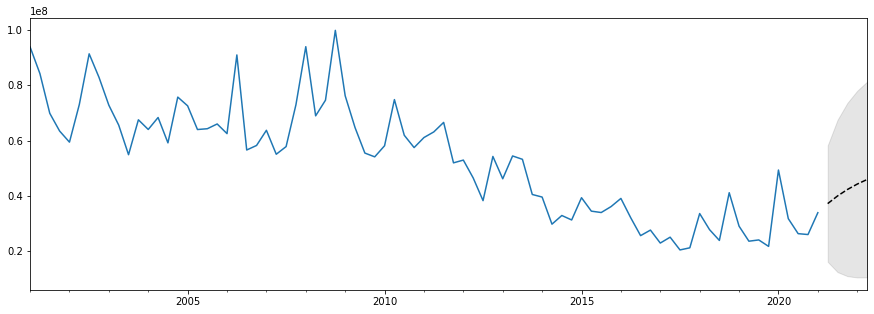

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
endog.loc['2001':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(5).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

In [35]:
# Step 1: fit model parameters w/ training sample
training_obs = int(len(endog) * 0.8)

training_endog = endog[:training_obs]
training_mod = sm.tsa.SARIMAX(training_endog, order=(1, 0, 0), trend='c')
training_res = training_mod.fit()

# Print the estimated parameters
print(training_res.params)

intercept    1.290507e+07
ar.L1        7.845346e-01
sigma2       1.163114e+14
dtype: float64


In [36]:
# Step 2: produce one-step-ahead forecasts
fcast = training_res.forecast()

# Step 3: compute root mean square forecasting error
true = endog.reindex(fcast.index)
error = true - fcast

# Print out the results
print(pd.concat([true.rename('true'),
                 fcast.rename('forecast'),
                 error.rename('error')], axis=1))

                true      forecast         error
2017Q1  2.295754e+07  3.459158e+07 -1.163404e+07


In [37]:
# Step 1: append a new observation to the sample and refit the parameters
append_res = training_res.append(endog[training_obs:training_obs + 1], refit=True)

# Print the re-estimated parameters
print(append_res.params)

intercept    1.290507e+07
ar.L1        7.833443e-01
sigma2       1.163114e+14
dtype: float64


In [38]:
# Step 2: produce one-step-ahead forecasts
fcast = append_res.forecast()

# Step 3: compute root mean square forecasting error
true = endog.reindex(fcast.index)
error = true - fcast

# Print out the results
print(pd.concat([true.rename('true'),
                 fcast.rename('forecast'),
                 error.rename('error')], axis=1))

                true      forecast         error
2017Q2  2.508137e+07  3.088873e+07 -5.807353e+06


In [39]:
# Setup forecasts
nforecasts = 3
forecasts = {}

# Get the number of initial training observations
nobs = len(endog)
n_init_training = int(nobs * 0.8)

# Create model for initial training sample, fit parameters
init_training_endog = endog.iloc[:n_init_training]
mod = sm.tsa.SARIMAX(training_endog, order=(1, 0, 0), trend='c')
res = mod.fit()

# Save initial forecast
forecasts[training_endog.index[-1]] = res.forecast(steps=nforecasts)

# Step through the rest of the sample
for t in range(n_init_training, nobs):
    # Update the results by appending the next observation
    updated_endog = endog.iloc[t:t+1]
    res = res.append(updated_endog, refit=False)
    # Save the new set of forecasts
    forecasts[updated_endog.index[0]] = res.forecast(steps=nforecasts)

# Combine all forecasts into a dataframe
forecasts = pd.concat(forecasts, axis=1)

print(forecasts.iloc[:5, :5])

              2016Q4        2017Q1        2017Q2        2017Q3        2017Q4
2017Q1  3.459158e+07           NaN           NaN           NaN           NaN
2017Q2  4.004336e+07  3.091605e+07           NaN           NaN           NaN
2017Q3  4.432048e+07  3.715978e+07  3.258228e+07           NaN           NaN
2017Q4           NaN  4.205821e+07  3.846700e+07  2.896818e+07           NaN
2018Q1           NaN           NaN  4.308376e+07  3.563161e+07  2.956808e+07


In [40]:
# Construct the forecast errors
forecast_errors = forecasts.apply(lambda column: endog - column).reindex(forecasts.index)

print(forecast_errors.iloc[:5, :5])

              2016Q4        2017Q1        2017Q2        2017Q3        2017Q4
2017Q1 -1.163404e+07           NaN           NaN           NaN           NaN
2017Q2 -1.496199e+07 -5.834680e+06           NaN           NaN           NaN
2017Q3 -2.384578e+07 -1.668509e+07 -1.210758e+07           NaN           NaN
2017Q4           NaN -2.081885e+07 -1.722764e+07 -7.728822e+06           NaN
2018Q1           NaN           NaN -9.466113e+06 -2.013961e+06  4.049568e+06


In [41]:
# Reindex the forecasts by horizon rather than by date
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')

print(flattened.iloc[:3, :5])

               2016Q4        2017Q1        2017Q2        2017Q3        2017Q4
horizon                                                                      
1       -1.163404e+07 -5.834680e+06 -1.210758e+07 -7.728822e+06  4.049568e+06
2       -1.496199e+07 -1.668509e+07 -1.722764e+07 -2.013961e+06 -8.287663e+06
3       -2.384578e+07 -2.081885e+07 -9.466113e+06 -1.304471e+07 -1.732003e+07


In [42]:
# Compute the root mean square error
rmse = (flattened**2).mean(axis=1)**0.5

print(rmse)

horizon
1    1.150161e+07
2    1.514996e+07
3    1.792962e+07
dtype: float64


In [43]:
# Setup forecasts
nforecasts = 3
forecasts = {}

# Get the number of initial training observations
nobs = len(endog)
n_init_training = int(nobs * 0.8)

# Create model for initial training sample, fit parameters
init_training_endog = endog.iloc[:n_init_training]
mod = sm.tsa.SARIMAX(training_endog, order=(1, 0, 0), trend='c')
res = mod.fit()

# Save initial forecast
forecasts[training_endog.index[-1]] = res.forecast(steps=nforecasts)

# Step through the rest of the sample
for t in range(n_init_training, nobs):
    # Update the results by appending the next observation
    updated_endog = endog.iloc[t:t+1]
    res = res.extend(updated_endog)
    
    # Save the new set of forecasts
    forecasts[updated_endog.index[0]] = res.forecast(steps=nforecasts)

# Combine all forecasts into a dataframe
forecasts = pd.concat(forecasts, axis=1)

print(forecasts.iloc[:5, :5])

              2016Q4        2017Q1        2017Q2        2017Q3        2017Q4
2017Q1  3.459158e+07           NaN           NaN           NaN           NaN
2017Q2  4.004336e+07  3.091605e+07           NaN           NaN           NaN
2017Q3  4.432048e+07  3.715978e+07  3.258228e+07           NaN           NaN
2017Q4           NaN  4.205821e+07  3.846700e+07  2.896818e+07           NaN
2018Q1           NaN           NaN  4.308376e+07  3.563161e+07  2.956808e+07


In [44]:
# Construct the forecast errors
forecast_errors = forecasts.apply(lambda column: endog - column).reindex(forecasts.index)

print(forecast_errors.iloc[:5, :5])

              2016Q4        2017Q1        2017Q2        2017Q3        2017Q4
2017Q1 -1.163404e+07           NaN           NaN           NaN           NaN
2017Q2 -1.496199e+07 -5.834680e+06           NaN           NaN           NaN
2017Q3 -2.384578e+07 -1.668509e+07 -1.210758e+07           NaN           NaN
2017Q4           NaN -2.081885e+07 -1.722764e+07 -7.728822e+06           NaN
2018Q1           NaN           NaN -9.466113e+06 -2.013961e+06  4.049568e+06


In [45]:
# Reindex the forecasts by horizon rather than by date
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')

print(flattened.iloc[:3, :5])

               2016Q4        2017Q1        2017Q2        2017Q3        2017Q4
horizon                                                                      
1       -1.163404e+07 -5.834680e+06 -1.210758e+07 -7.728822e+06  4.049568e+06
2       -1.496199e+07 -1.668509e+07 -1.722764e+07 -2.013961e+06 -8.287663e+06
3       -2.384578e+07 -2.081885e+07 -9.466113e+06 -1.304471e+07 -1.732003e+07


In [46]:
# Compute the root mean square error
rmse = (flattened**2).mean(axis=1)**0.5

print(rmse)

horizon
1    1.150161e+07
2    1.514996e+07
3    1.792962e+07
dtype: float64


In [47]:
print(endog.index)

PeriodIndex(['2001Q1', '2001Q2', '2001Q3', '2001Q4', '2002Q1', '2002Q2',
             '2002Q3', '2002Q4', '2003Q1', '2003Q2', '2003Q3', '2003Q4',
             '2004Q1', '2004Q2', '2004Q3', '2004Q4', '2005Q1', '2005Q2',
             '2005Q3', '2005Q4', '2006Q1', '2006Q2', '2006Q3', '2006Q4',
             '2007Q1', '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2',
             '2008Q3', '2008Q4', '2009Q1', '2009Q2', '2009Q3', '2009Q4',
             '2010Q1', '2010Q2', '2010Q3', '2010Q4', '2011Q1', '2011Q2',
             '2011Q3', '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4',
             '2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2',
             '2014Q3', '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4',
             '2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2',
             '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4',
             '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2020Q2',
             '2020Q3', '2020Q4', '2021Q1'],
       

In [48]:
# Annual frequency, using a PeriodIndex
index = pd.period_range(start='2001', periods=4, freq='A')
endog1 = pd.Series([1, 2, 3, 4], index=index)
print(endog1.index)

PeriodIndex(['2001', '2002', '2003', '2004'], dtype='period[A-DEC]')


In [49]:
# Quarterly frequency, using a DatetimeIndex
index = pd.date_range(start='2001', periods=4, freq='QS')
endog2 = pd.Series([1, 2, 3, 4], index=index)
print(endog2.index)

DatetimeIndex(['2001-01-01', '2001-04-01', '2001-07-01', '2001-10-01'], dtype='datetime64[ns]', freq='QS-JAN')


In [50]:
# Monthly frequency, using a DatetimeIndex
index = pd.date_range(start='2001', periods=4, freq='M')
endog3 = pd.Series([1, 2, 3, 4], index=index)
print(endog3.index)

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30'], dtype='datetime64[ns]', freq='M')


In [51]:
index = pd.DatetimeIndex([
    '2001-01-01 10:08am', '2001-01-01 11:32am',
    '2001-01-01 5:32pm', '2001-01-02 6:15am'])
endog4 = pd.Series([0.2, 0.5, -0.1, 0.1], index=index)
print(endog4.index)

DatetimeIndex(['2001-01-01 10:08:00', '2001-01-01 11:32:00',
               '2001-01-01 17:32:00', '2001-01-02 06:15:00'],
              dtype='datetime64[ns]', freq=None)


In [52]:
mod = sm.tsa.SARIMAX(endog4)
res = mod.fit()

c:\Users\mat98\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mat98\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [53]:
res.forecast(1)

c:\Users\mat98\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


4    0.011866
dtype: float64

In [54]:
# Here we'll catch the exception to prevent printing too much of
# the exception trace output in this notebook
try:
    res.forecast('2010-01-03')
except KeyError as e:
    print(e)

'The `end` argument could not be matched to a location related to the index of the data.'
